<font size='5'> <center> <u>**CNN Demo**</u></center></font>

This notebook is a concise demo of implementing convolutionary neural network (CNN) using PyTorch.

In [1]:
import torch
from torch import nn

**Limitation of Multi Layer Perceptron (MLP)**

Consider a MLP with the hidden layer $\mathbf{H}$ right after the 2D image input $\mathbf{X}$. In order to calculate the weight at position $(i, j)$ of $\mathbf{H}$, we need to consider all the weights in the input image $\mathbf{X}$, which is not efficient. The following sketch shows that this leads to $O(n^4)$ complexity!

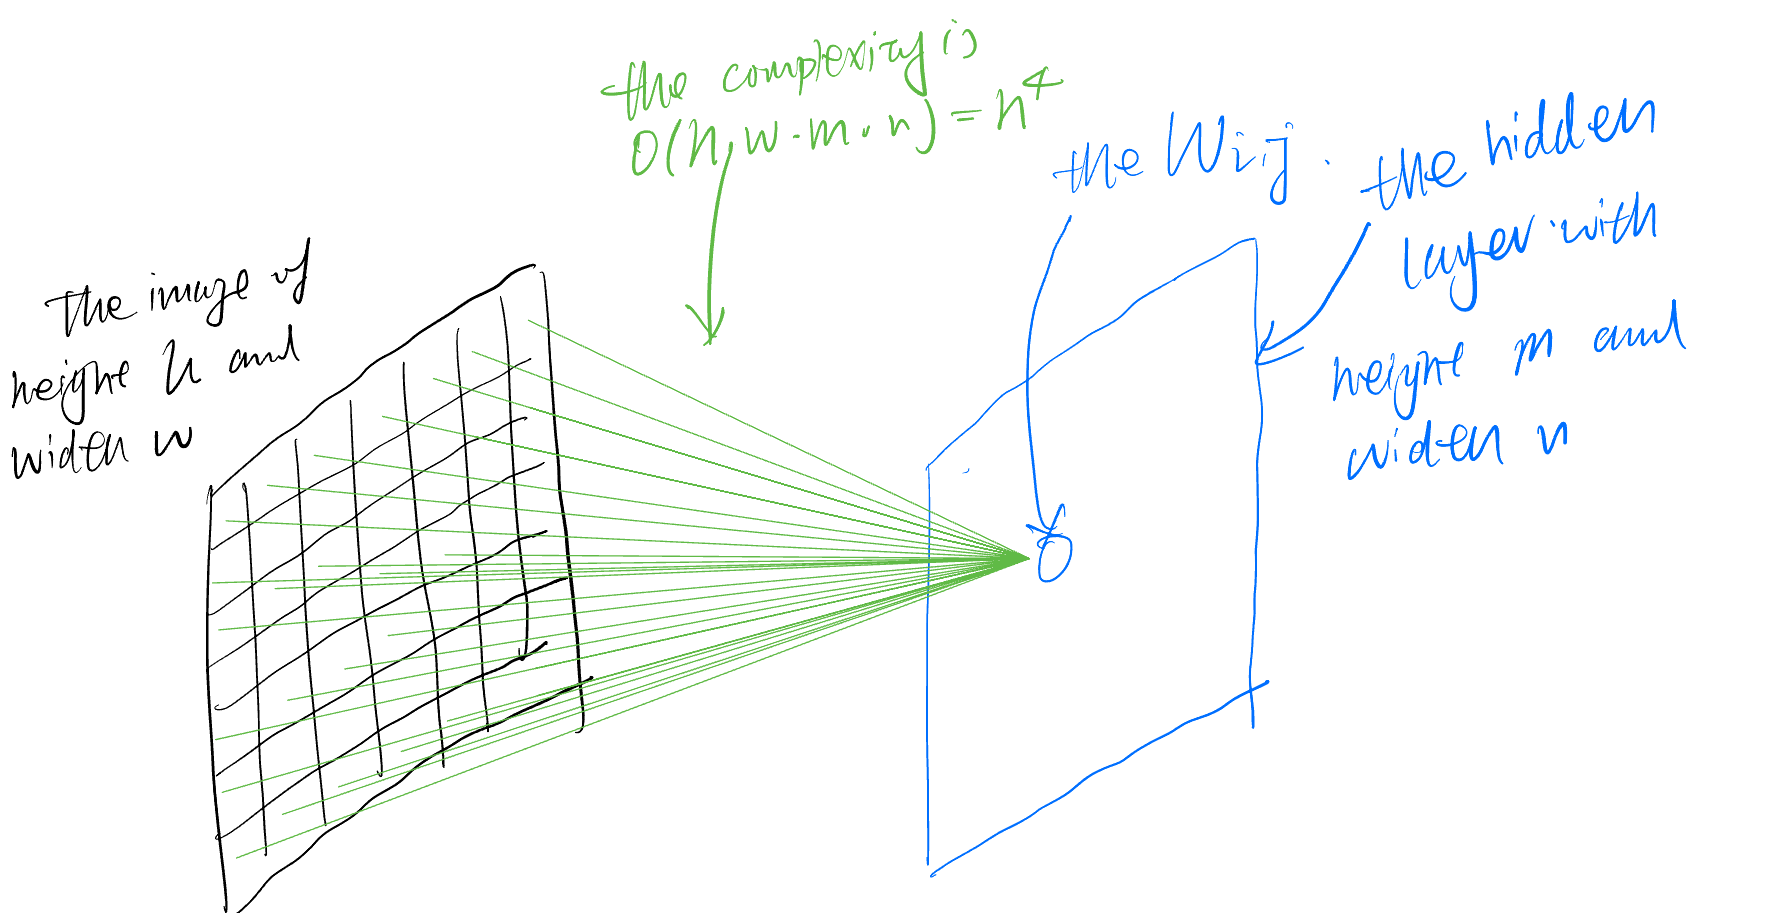

In order to show how <u>*translation invariance*</u> can help us to resolve this issue, we make the value of $k$ and $l$ to be calculated indirectly by $(i + a, j + b)$ where $a$ and $b$ are just offset from $i$ and $j$. Here $U$ is the unbiased estimator and $V$ is the the higher order weight matrix.

$$\begin{aligned} 
\left[\mathbf{H}\right]_{i, j} &= [\mathbf{U}]_{i, j} + \sum_k \sum_l[\mathsf{W}]_{i, j, k, l} [\mathbf{X}]_{k, l}\\ 
&=  [\mathbf{U}]_{i, j} + \sum_a \sum_b [\mathsf{V}]_{i, j, a, b}  [\mathbf{X}]_{i+a, j+b}.
\end{aligned}$$

**Translation Invariance**

It is hypothesised that the $V$ and $U$ does not depend on the location $(i, j)$. Intuitively, there are simpler (less wieghts) and more generic way to encapsulate the characteristics of an group of image input. Once we remove the dependence of $V$ and $U$ on location $(i, j)$, $U$ simply becomes a constant and $V$ becomes a 2 dimensional matrixed (called convolutionary kernel). 

$$
[\mathbf{H}]_{i, j} = u + \sum_a\sum_b [\mathbf{V}]_{a, b}  [\mathbf{X}]_{i+a, j+b}.
$$

**Locality**

> The earliest layers of the network should focus on local regions, without regard for the contents of the image in distant regions. This is the *locality principle*. Eventually, these local representations can be aggregated to make predictions at the whole image level.

Locality principle involves first finding local and small heuristic patterns in the image, then combining them latter to make a decision. This is achieved by using a relatively small $\Delta$ (typically 3 depending on needs) which helps to calcuate the weight at position $(i, j)$ of $\mathbf{H}$ as follows:

$$
[\mathbf{H}]_{i, j} = u + \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} [\mathbf{V}]_{a, b}  [\mathbf{X}]_{i+a, j+b}.
$$

**The Cross-Correlation Operation**

Technically, the operation above is called *cross-correlation* and not convolution. Since convolution is a mathematical operation that requires flipping the kernel (Think of fliping the function below, *kernal can be viewed as a function*). However, in practice, the difference between the two is not significant (see this [post](https://www.kaggle.com/discussions/general/225375)). 

$$(f * g)(\mathbf{x}) = \int f(\mathbf{z}) g(\mathbf{x}-\mathbf{z}) d\mathbf{z}.$$

Note that usually, when performing cross-correlation operation, it results in smaller output size than the input size. This is because the kernel is not allowed to go outside the input image. The new size is calculated as:

$$(n_\textrm{h}-k_\textrm{h}+1) \times (n_\textrm{w}-k_\textrm{w}+1).$$


In [2]:
def corr2d(X, K):
    """Compute 2D cross-correlation."""
    h, w = K.shape # K is the parameter
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1)) # calculate smaller weight matrix
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum() # dot product of weight matrix and input image matrix
    return Y

The following example use 

$$
X = \begin{bmatrix}
0.0 & 1.0 & 2.0 \\
3.0 & 4.0 & 5.0 \\
6.0 & 7.0 & 8.0
\end{bmatrix}

K = \begin{bmatrix}
0.0 & 1.0 \\
2.0 & 3.0
\end{bmatrix}
$$

We first calculate $H_{00}$ by 
$$
H_{00} =
\begin{bmatrix}
0.0 & 1.0 \\
2.0 & 3.0
\end{bmatrix}
\cdot
\begin{bmatrix}
0.0 & 1.0 \\
3.0 & 4.0 \\
\end{bmatrix}
= 19
$$

In [3]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

We can abstract this convolution layer as a PyTorch module.

In [4]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

**Example: Object Edge Detection**

The following example show how to use convolution layer to detect object edges in an image.

In [5]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

We define a $2 \times 1$ kernel vector $K$. This size of chosen because there is an changes of intensity of pixels in the vertical direction. This heuristic can be captures by the $K$ of this minimal size.

In [6]:
K = torch.tensor([[1.0, -1.0]])

The border is obtained by this pre-defined kernel $K$ and the image $X$ by the following operation:

In [7]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [8]:
# Question: Can we detect orthogonal lines? Answer: YES!
M = torch.zeros((7, 7))
for i in range(7):
    M[i, i] = 1
    M[i, 6-i] = 1
print(M)

N = corr2d(M, K)
N

tensor([[1., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 1.]])


tensor([[ 1.,  0.,  0.,  0.,  0., -1.],
        [-1.,  1.,  0.,  0., -1.,  1.],
        [ 0., -1.,  1., -1.,  1.,  0.],
        [ 0.,  0., -1.,  1.,  0.,  0.],
        [ 0., -1.,  1., -1.,  1.,  0.],
        [-1.,  1.,  0.,  0., -1.,  1.],
        [ 1.,  0.,  0.,  0.,  0., -1.]])

In [9]:
# dynamically adapt to input size
conv2d = nn.LazyConv2d(out_channels=1, kernel_size=(1, 2), bias=False)

# The two-dimensional convolutional layer uses four-dimensional input and
# output in the format of (example, channel, height, width), where the batch
# size (number of examples in the batch) and the number of channels are both 1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2  # Learning rate

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2 # loss
    conv2d.zero_grad()
    l.sum().backward()
    # Update the kernel
    conv2d.weight.data[:] -= lr * conv2d.weight.grad # simple sgd
    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.sum():.3f}')


epoch 2, loss 9.471
epoch 4, loss 1.689
epoch 6, loss 0.324
epoch 8, loss 0.071
epoch 10, loss 0.019


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [10]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 0.9732, -0.9955]])

In [11]:
import torch

torch.stack((torch.eye(2), torch.eye(2), torch.eye(2)), -1)

tensor([[[1., 1., 1.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [1., 1., 1.]]])

#### Implementing LeNet

In this example, we will implement the LeNet architecture. The LeNet architecture is a classic CNN architecture that was introduced by Yann LeCun in 1998. The architecture is composed of the following layers:

(1) Image 28x28

(2) Conv (5x5 kernel, 6 channels)

(3) AvgPool (2x2 shape, stride 2)

(4) Conv (5x5 kernel, 16 channels)

(5) AvgPool (2x2 shape, stride 2)

(6) FC (120 neurons)

(7) FC (84 neurons)

(8) FC (10 neurons)

In [12]:
from d2l import torch as d2l

class LeNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(out_channels=6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(out_channels=16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(10))
        
    def layer_summary(self, X_shape):
        X = torch.randn(*X_shape) # note: the size is dynamically inferred
        for layer in self.net:
            X = layer(X)
            print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()
model.layer_summary((1, 1, 28, 28)) # dp, channel, width, height

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([128, 1, 28, 28])

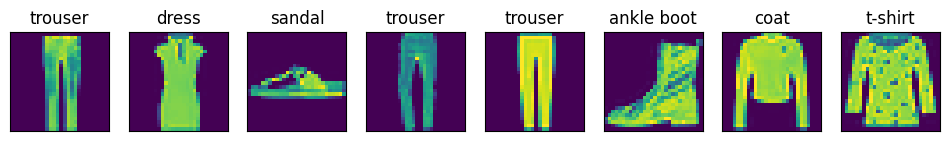

In [13]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
batch = next(iter(data.get_dataloader(train=True)))
data.visualize(batch)

dp = batch[0] # x axies of dp
dp.shape

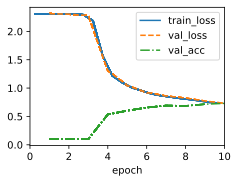

In [14]:
model = LeNet()

def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)

# derive network parameters from a single example input
# initialize weights
model.apply_init([dp], init_weights)

# train the model
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(model, data)